<a href="https://colab.research.google.com/github/uladzimirkapeika/1c_sales/blob/master/25gb_1c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import libraries

In [1]:
!pip install neptune-client
!pip install neptune-client neptune-contrib[monitoring]

     |████████████████████████████████| 92kB 4.7MB/s 
     |████████████████████████████████| 829kB 14.4MB/s 
     |████████████████████████████████| 61kB 6.4MB/s 
     |████████████████████████████████| 204kB 18.4MB/s 
     |████████████████████████████████| 163kB 21.7MB/s 
     |████████████████████████████████| 143kB 29.0MB/s 
     |████████████████████████████████| 71kB 7.8MB/s 
     |████████████████████████████████| 133kB 30.3MB/s 
     |████████████████████████████████| 71kB 7.4MB/s 
  Created wheel for neptune-client: filename=neptune_client-0.4.119-py2.py3-none-any.whl size=150019 sha256=a9a007ad1c37c4594c2379459b281653333906a60e36a4e4e5a897e984be0094
  Stored in directory: /root/.cache/pip/wheels/84/5c/c1/a81e80761b94b4467fd3fda1fd3109463702f6247fc422eb33
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=451e322f905916b3f0aba92ee5e6f97df7c7e099b99752f7d79c221e06a88c90
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.feature_extraction.text import TfidfVectorizer
import neptune
from neptunecontrib.monitoring.lightgbm import neptune_monitor
import joblib
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Read data

In [3]:
test = pd.read_csv('/content/drive/My Drive/1C/test.csv')
sales = pd.read_csv('/content/drive/My Drive/1C/sales_train.csv')
shops = pd.read_csv('/content/drive/My Drive/1C//shops.csv')
items = pd.read_csv('/content/drive/My Drive/1C/items.csv')
item_cats = pd.read_csv('/content/drive/My Drive/1C/item_categories.csv')

In [4]:
sales = sales[sales['item_price'] > 0]

Shops

In [5]:
shops['city'] = shops['shop_name'].apply(lambda x: x.split()[0].lower())
shops.loc[shops.city == '!якутск', 'city'] = 'якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])

coords = dict()
coords['якутск'] = (62.028098, 129.732555, 4)
coords['адыгея'] = (44.609764, 40.100516, 3)
coords['балашиха'] = (55.8094500, 37.9580600, 1)
coords['волжский'] = (53.4305800, 50.1190000, 3)
coords['вологда'] = (59.2239000, 39.8839800, 2)
coords['воронеж'] = (51.6720400, 39.1843000, 3)
coords['выездная'] = (0, 0, 0)
coords['жуковский'] = (55.5952800, 38.1202800, 1)
coords['интернет-магазин'] = (0, 0, 0)
coords['казань'] = (55.7887400, 49.1221400, 4)
coords['калуга'] = (54.5293000, 36.2754200, 4)
coords['коломна'] = (55.0794400, 38.7783300, 4)
coords['красноярск'] = (56.0183900, 92.8671700, 4)
coords['курск'] = (51.7373300, 36.1873500, 3)
coords['москва'] = (55.7522200, 37.6155600, 1)
coords['мытищи'] = (55.9116300, 37.7307600, 1)
coords['н.новгород'] = (56.3286700, 44.0020500, 4)
coords['новосибирск'] = (55.0415000, 82.9346000, 4)
coords['омск'] = (54.9924400, 73.3685900, 4)
coords['ростовнадону'] = (47.2313500, 39.7232800, 3)
coords['спб'] = (59.9386300, 30.3141300, 2)
coords['самара'] = (53.2000700, 50.1500000, 4)
coords['сергиев'] = (56.3000000, 38.1333300, 4)
coords['сургут'] = (61.2500000, 73.4166700, 4)
coords['томск'] = (56.4977100, 84.9743700, 4)
coords['тюмень'] = (57.1522200, 65.5272200, 4)
coords['уфа'] = (54.7430600, 55.9677900, 4)
coords['химки'] = (55.8970400, 37.4296900, 1)
coords['цифровой'] = (0, 0, 0)
coords['чехов'] = (55.1477000, 37.4772800, 4)
coords['ярославль'] = (57.6298700, 39.8736800, 2) 

shops['city_coord_1'] = shops['city'].apply(lambda x: coords[x][0])
shops['city_coord_2'] = shops['city'].apply(lambda x: coords[x][1])
shops['country_part'] = shops['city'].apply(lambda x: coords[x][2])

shops = shops[['shop_id', 'city_code', 'city_coord_1', 'city_coord_2', 'country_part']]

In [6]:
shops.head(5)

,shop_id,city_code,city_coord_1,city_coord_2,country_part
0,0,29,62.028098,129.732555,4
1,1,29,62.028098,129.732555,4
2,2,0,44.609764,40.100516,3
3,3,1,55.809450,37.958060,1
4,4,2,53.430580,50.119000,3


In [7]:
items = pd.merge(items, item_cats, on='item_category_id')
items['item_category_name'].unique()
items['item_category'] = items['item_category_name'].apply(lambda x: x.split('-')[0])

map_dict = {
            'Чистые носители (штучные)': 'Чистые носители',
            'Чистые носители (шпиль)' : 'Чистые носители',
            'PC ': 'Аксессуары',
            'Служебные': 'Служебные '
            }
items['item_category'] = items['item_category'].apply(lambda x: map_dict[x] if x in map_dict.keys() else x)

items['item_category_common'] = LabelEncoder().fit_transform(items['item_category'])
items['item_category_code'] = LabelEncoder().fit_transform(items['item_category_name'])
items = items[['item_id', 'item_category_common', 'item_category_code']]

# Create dataset

In [8]:
train = sales[sales.item_price < 100000]
train = train[sales.item_cnt_day < 1001]

train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57

train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58

train.loc[train.shop_id == 40, 'shop_id'] = 39
test.loc[test.shop_id == 40, 'shop_id'] = 39

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [9]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

df = [] 
for block_num in train['date_block_num'].unique():
    cur_shops = train.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = train.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    df.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

df = pd.DataFrame(np.vstack(df), columns = index_cols,dtype=np.int32)
df.head(5)

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0


In [10]:
#Add month sales
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

df = pd.merge(df, group, on=index_cols, how='left')
df['item_cnt_month'] = (df['item_cnt_month']
                                .fillna(0)
                                .clip(0,20)
                                .astype(np.float16))
df.head(5)

,shop_id,item_id,date_block_num,item_cnt_month
0,59,22154,0,1.0
1,59,2552,0,0.0
2,59,2554,0,0.0
3,59,2555,0,0.0
4,59,2564,0,0.0


In [11]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)
df = pd.concat([df, test], ignore_index=True, sort=False, keys=index_cols)
df.fillna(0, inplace=True)
df.head(5)

,shop_id,item_id,date_block_num,item_cnt_month,ID
0,59,22154,0,1.0,0.0
1,59,2552,0,0.0,0.0
2,59,2554,0,0.0,0.0
3,59,2555,0,0.0,0.0
4,59,2564,0,0.0,0.0


In [12]:
# Add items and shops features
df = pd.merge(df, items, on=['item_id'], how='left')
df = pd.merge(df, shops, on=['shop_id'], how='left')

In [13]:
#Calculate intersection features

df1 = df.copy()
first_shop_item_block = df1.groupby(['shop_id', 'item_id'])['date_block_num'].min().reset_index()
first_shop_item_block['shop_item_first_interaction'] = 1

first_item_block = df1.groupby(['item_id'])['date_block_num'].min().reset_index()
first_item_block['item_first_interaction'] = 1

first_shop_item_buy_block = df1[df1['date_block_num'] > 0].groupby(['shop_id', 'item_id'])['date_block_num'].min().reset_index()
first_shop_item_buy_block['first_date_block_num'] = first_shop_item_buy_block['date_block_num']




In [14]:
df = pd.merge(df, first_shop_item_block[['item_id', 'shop_id', 'date_block_num', 'shop_item_first_interaction']], on=['item_id', 'shop_id', 'date_block_num'], how='left')
df = pd.merge(df, first_item_block[['item_id', 'date_block_num', 'item_first_interaction']], on=['item_id', 'date_block_num'], how='left')
df = pd.merge(df, first_shop_item_buy_block[['item_id', 'shop_id', 'first_date_block_num']], on=['item_id', 'shop_id'], how='left')

df['first_date_block_num'].fillna(100, inplace=True)
df['shop_item_sold_before'] = (df['first_date_block_num'] < df['date_block_num']).astype('int8')
df.drop(['first_date_block_num'], axis=1, inplace=True)

df['item_first_interaction'].fillna(0, inplace=True)
df['shop_item_first_interaction'].fillna(0, inplace=True)
df['shop_item_sold_before'].fillna(0, inplace=True)

df['shop_item_first_interaction'] = df['shop_item_first_interaction'].astype('int8')  
df['item_first_interaction'] = df['item_first_interaction'].astype('int8')  
df['shop_item_sold_before'] = df['shop_item_sold_before'].astype('int8') 


In [15]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
        df[col+'_lag_'+str(i)] = df[col+'_lag_'+str(i)].astype('float32')
    return df

df = lag_feature(df, [1, 2, 3], 'item_cnt_month')
#df.fillna(0, inplace=True)

In [16]:
def lag_feature_adv(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)+'_adv']
        shifted['date_block_num'] += i
        shifted['item_id'] -= 1
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
        df[col+'_lag_'+str(i)+'_adv'] = df[col+'_lag_'+str(i)+'_adv'].astype('float32')
    return df

df = lag_feature_adv(df, [1, 2, 3], 'item_cnt_month')

In [17]:
#avg shop/item price
index_cols = ['shop_id', 'item_id', 'date_block_num']
group = train.groupby(index_cols)['item_price'].mean().reset_index().rename(columns={"item_price": "avg_shop_price"}, errors="raise")
df = pd.merge(df, group, on=index_cols, how='left')

df['avg_shop_price'] = (df['avg_shop_price']
                                .fillna(0)
                                .astype(np.float16))

#avg item price
index_cols = ['item_id', 'date_block_num']
group = train.groupby(['date_block_num','item_id'])['item_price'].mean().reset_index().rename(columns={"item_price": "avg_item_price"}, errors="raise")


df = pd.merge(df, group, on=index_cols, how='left')
df['avg_item_price'] = (df['avg_item_price']
                                .fillna(0)
                                .astype(np.float16))
df['item_shop_price_avg'] = (df['avg_shop_price'] - df['avg_item_price']) / df['avg_item_price']
df = lag_feature(df, [1, 2, 3], 'item_shop_price_avg')
df.head(5)

,shop_id,item_id,date_block_num,item_cnt_month,ID,item_category_common,item_category_code,city_code,city_coord_1,city_coord_2,country_part,shop_item_first_interaction,item_first_interaction,shop_item_sold_before,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_1_adv,item_cnt_month_lag_2_adv,item_cnt_month_lag_3_adv,avg_shop_price,avg_item_price,item_shop_price_avg,item_shop_price_avg_lag_1,item_shop_price_avg_lag_2,item_shop_price_avg_lag_3
0,59,22154,0,1.0,0.0,11,37,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,999.0,999.0,0.0,NaN,NaN,NaN
1,59,2552,0,0.0,0.0,13,58,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,899.0,-1.0,NaN,NaN,NaN
2,59,2554,0,0.0,0.0,13,58,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1709.0,-1.0,NaN,NaN,NaN
3,59,2555,0,0.0,0.0,13,56,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1099.0,-1.0,NaN,NaN,NaN
4,59,2564,0,0.0,0.0,13,59,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,327.5,-1.0,NaN,NaN,NaN


In [18]:
#add date features

import calendar
from datetime import datetime

def count_days(date_block_num):
    year = 2013 + date_block_num // 12
    month = 1 + date_block_num % 12
    weeknd_count = len([1 for i in calendar.monthcalendar(year, month) if i[6] != 0])
    days_in_month = calendar.monthrange(year, month)[1]
    return weeknd_count, days_in_month, month

map_dict = {i: count_days(i) for i in range(35)}

df['weeknd_count'] = df['date_block_num'].apply(lambda x: map_dict[x][0])
df['days_in_month'] = df['date_block_num'].apply(lambda x: map_dict[x][1])

In [19]:
item_id_target_mean = df.groupby(['date_block_num','item_id'])['item_cnt_month'].mean().reset_index().rename(columns={"item_cnt_month": "item_target_enc"}, errors="raise")
df = pd.merge(df, item_id_target_mean, on=['date_block_num','item_id'], how='left')

df['item_target_enc'] = (df['item_target_enc']
                                .fillna(0)
                                .astype(np.float16))

df = lag_feature(df, [1, 2, 3], 'item_target_enc')
df.head(5)

,shop_id,item_id,date_block_num,item_cnt_month,ID,item_category_common,item_category_code,city_code,city_coord_1,city_coord_2,country_part,shop_item_first_interaction,item_first_interaction,shop_item_sold_before,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_1_adv,item_cnt_month_lag_2_adv,item_cnt_month_lag_3_adv,avg_shop_price,avg_item_price,item_shop_price_avg,item_shop_price_avg_lag_1,item_shop_price_avg_lag_2,item_shop_price_avg_lag_3,weeknd_count,days_in_month,item_target_enc,item_target_enc_lag_1,item_target_enc_lag_2,item_target_enc_lag_3
0,59,22154,0,1.0,0.0,11,37,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,999.0,999.0,0.0,NaN,NaN,NaN,4,31,0.399902,NaN,NaN,NaN
1,59,2552,0,0.0,0.0,13,58,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,899.0,-1.0,NaN,NaN,NaN,4,31,0.000000,NaN,NaN,NaN
2,59,2554,0,0.0,0.0,13,58,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1709.0,-1.0,NaN,NaN,NaN,4,31,0.022217,NaN,NaN,NaN
3,59,2555,0,0.0,0.0,13,56,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1099.0,-1.0,NaN,NaN,NaN,4,31,0.044434,NaN,NaN,NaN
4,59,2564,0,0.0,0.0,13,59,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,327.5,-1.0,NaN,NaN,NaN,4,31,0.111084,NaN,NaN,NaN


In [20]:
item_id_target_mean = df.groupby(['date_block_num','item_id', 'city_code'])['item_cnt_month'].mean().reset_index().rename(columns={
    "item_cnt_month": "item_loc_target_enc"}, errors="raise")
df = pd.merge(df, item_id_target_mean, on=['date_block_num','item_id', 'city_code'], how='left')

df['item_loc_target_enc'] = (df['item_loc_target_enc']
                                .fillna(0)
                                .astype(np.float16))

df = lag_feature(df, [1, 2, 3], 'item_loc_target_enc')
df.head(5)

,shop_id,item_id,date_block_num,item_cnt_month,ID,item_category_common,item_category_code,city_code,city_coord_1,city_coord_2,country_part,shop_item_first_interaction,item_first_interaction,shop_item_sold_before,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_1_adv,item_cnt_month_lag_2_adv,item_cnt_month_lag_3_adv,avg_shop_price,avg_item_price,item_shop_price_avg,item_shop_price_avg_lag_1,item_shop_price_avg_lag_2,item_shop_price_avg_lag_3,weeknd_count,days_in_month,item_target_enc,item_target_enc_lag_1,item_target_enc_lag_2,item_target_enc_lag_3,item_loc_target_enc,item_loc_target_enc_lag_1,item_loc_target_enc_lag_2,item_loc_target_enc_lag_3
0,59,22154,0,1.0,0.0,11,37,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,999.0,999.0,0.0,NaN,NaN,NaN,4,31,0.399902,NaN,NaN,NaN,1.0,NaN,NaN,NaN
1,59,2552,0,0.0,0.0,13,58,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,899.0,-1.0,NaN,NaN,NaN,4,31,0.000000,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2,59,2554,0,0.0,0.0,13,58,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1709.0,-1.0,NaN,NaN,NaN,4,31,0.022217,NaN,NaN,NaN,0.0,NaN,NaN,NaN
3,59,2555,0,0.0,0.0,13,56,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1099.0,-1.0,NaN,NaN,NaN,4,31,0.044434,NaN,NaN,NaN,0.0,NaN,NaN,NaN
4,59,2564,0,0.0,0.0,13,59,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,327.5,-1.0,NaN,NaN,NaN,4,31,0.111084,NaN,NaN,NaN,0.0,NaN,NaN,NaN


In [21]:
item_id_target_mean = df.groupby(['date_block_num','item_id', 'shop_id'])['item_cnt_month'].mean().reset_index().rename(columns={
    "item_cnt_month": "item_shop_target_enc"}, errors="raise")

df = pd.merge(df, item_id_target_mean, on=['date_block_num','item_id', 'shop_id'], how='left')

df['item_shop_target_enc'] = (df['item_shop_target_enc']
                                .fillna(0)
                                .astype(np.float16))

df = lag_feature(df, [1, 2, 3], 'item_shop_target_enc')
df.head(5)

,shop_id,item_id,date_block_num,item_cnt_month,ID,item_category_common,item_category_code,city_code,city_coord_1,city_coord_2,country_part,shop_item_first_interaction,item_first_interaction,shop_item_sold_before,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_1_adv,item_cnt_month_lag_2_adv,item_cnt_month_lag_3_adv,avg_shop_price,avg_item_price,item_shop_price_avg,item_shop_price_avg_lag_1,item_shop_price_avg_lag_2,item_shop_price_avg_lag_3,weeknd_count,days_in_month,item_target_enc,item_target_enc_lag_1,item_target_enc_lag_2,item_target_enc_lag_3,item_loc_target_enc,item_loc_target_enc_lag_1,item_loc_target_enc_lag_2,item_loc_target_enc_lag_3,item_shop_target_enc,item_shop_target_enc_lag_1,item_shop_target_enc_lag_2,item_shop_target_enc_lag_3
0,59,22154,0,1.0,0.0,11,37,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,999.0,999.0,0.0,NaN,NaN,NaN,4,31,0.399902,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN
1,59,2552,0,0.0,0.0,13,58,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,899.0,-1.0,NaN,NaN,NaN,4,31,0.000000,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2,59,2554,0,0.0,0.0,13,58,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1709.0,-1.0,NaN,NaN,NaN,4,31,0.022217,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN
3,59,2555,0,0.0,0.0,13,56,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1099.0,-1.0,NaN,NaN,NaN,4,31,0.044434,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN
4,59,2564,0,0.0,0.0,13,59,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,327.5,-1.0,NaN,NaN,NaN,4,31,0.111084,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN


In [22]:
item_id_target_mean = df[df['item_first_interaction'] == 1].groupby(['date_block_num','item_category_code', 'shop_id'])['item_cnt_month'].mean().reset_index().rename(columns={
    "item_cnt_month": "new_item_shop_cat_avg"}, errors="raise")

df = pd.merge(df, item_id_target_mean, on=['date_block_num','item_category_code', 'shop_id'], how='left')

df['new_item_shop_cat_avg'] = (df['new_item_shop_cat_avg']
                                .fillna(0)
                                .astype(np.float16))

df = lag_feature(df, [1, 2, 3], 'new_item_shop_cat_avg')
df.head(5)

,shop_id,item_id,date_block_num,item_cnt_month,ID,item_category_common,item_category_code,city_code,city_coord_1,city_coord_2,country_part,shop_item_first_interaction,item_first_interaction,shop_item_sold_before,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_1_adv,item_cnt_month_lag_2_adv,item_cnt_month_lag_3_adv,avg_shop_price,avg_item_price,item_shop_price_avg,item_shop_price_avg_lag_1,item_shop_price_avg_lag_2,item_shop_price_avg_lag_3,weeknd_count,days_in_month,item_target_enc,item_target_enc_lag_1,item_target_enc_lag_2,item_target_enc_lag_3,item_loc_target_enc,item_loc_target_enc_lag_1,item_loc_target_enc_lag_2,item_loc_target_enc_lag_3,item_shop_target_enc,item_shop_target_enc_lag_1,item_shop_target_enc_lag_2,item_shop_target_enc_lag_3,new_item_shop_cat_avg,new_item_shop_cat_avg_lag_1,new_item_shop_cat_avg_lag_2,new_item_shop_cat_avg_lag_3
0,59,22154,0,1.0,0.0,11,37,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,999.0,999.0,0.0,NaN,NaN,NaN,4,31,0.399902,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.088501,NaN,NaN,NaN
1,59,2552,0,0.0,0.0,13,58,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,899.0,-1.0,NaN,NaN,NaN,4,31,0.000000,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
2,59,2554,0,0.0,0.0,13,58,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1709.0,-1.0,NaN,NaN,NaN,4,31,0.022217,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
3,59,2555,0,0.0,0.0,13,56,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1099.0,-1.0,NaN,NaN,NaN,4,31,0.044434,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.008331,NaN,NaN,NaN
4,59,2564,0,0.0,0.0,13,59,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,327.5,-1.0,NaN,NaN,NaN,4,31,0.111084,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.011978,NaN,NaN,NaN


In [23]:
item_id_target_mean = df[df['item_first_interaction'] == 1].groupby(['date_block_num','item_category_code'])['item_cnt_month'].mean().reset_index().rename(columns={
    "item_cnt_month": "new_item_cat_avg"}, errors="raise")

df = pd.merge(df, item_id_target_mean, on=['date_block_num','item_category_code'], how='left')

df['new_item_cat_avg'] = (df['new_item_cat_avg']
                                .fillna(0)
                                .astype(np.float16))

df = lag_feature(df, [1, 2, 3], 'new_item_cat_avg')
df.head(5)

,shop_id,item_id,date_block_num,item_cnt_month,ID,item_category_common,item_category_code,city_code,city_coord_1,city_coord_2,country_part,shop_item_first_interaction,item_first_interaction,shop_item_sold_before,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_1_adv,item_cnt_month_lag_2_adv,item_cnt_month_lag_3_adv,avg_shop_price,avg_item_price,item_shop_price_avg,item_shop_price_avg_lag_1,item_shop_price_avg_lag_2,item_shop_price_avg_lag_3,weeknd_count,days_in_month,item_target_enc,item_target_enc_lag_1,item_target_enc_lag_2,item_target_enc_lag_3,item_loc_target_enc,item_loc_target_enc_lag_1,item_loc_target_enc_lag_2,item_loc_target_enc_lag_3,item_shop_target_enc,item_shop_target_enc_lag_1,item_shop_target_enc_lag_2,item_shop_target_enc_lag_3,new_item_shop_cat_avg,new_item_shop_cat_avg_lag_1,new_item_shop_cat_avg_lag_2,new_item_shop_cat_avg_lag_3,new_item_cat_avg,new_item_cat_avg_lag_1,new_item_cat_avg_lag_2,new_item_cat_avg_lag_3
0,59,22154,0,1.0,0.0,11,37,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,999.0,999.0,0.0,NaN,NaN,NaN,4,31,0.399902,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.088501,NaN,NaN,NaN,0.196045,NaN,NaN,NaN
1,59,2552,0,0.0,0.0,13,58,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,899.0,-1.0,NaN,NaN,NaN,4,31,0.000000,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.043549,NaN,NaN,NaN
2,59,2554,0,0.0,0.0,13,58,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1709.0,-1.0,NaN,NaN,NaN,4,31,0.022217,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.043549,NaN,NaN,NaN
3,59,2555,0,0.0,0.0,13,56,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1099.0,-1.0,NaN,NaN,NaN,4,31,0.044434,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.008331,NaN,NaN,NaN,0.049622,NaN,NaN,NaN
4,59,2564,0,0.0,0.0,13,59,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,327.5,-1.0,NaN,NaN,NaN,4,31,0.111084,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.011978,NaN,NaN,NaN,0.093262,NaN,NaN,NaN


In [24]:
#df.fillna(0, inplace=True)
#df['delta_count_month_1'] = (df['item_cnt_month_lag_1'] - (df['item_cnt_month_lag_2'])) / (df['item_cnt_month_lag_2'])
#df['delta_count_month_2'] = (df['item_cnt_month_lag_2'] - (df['item_cnt_month_lag_3'])) / (df['item_cnt_month_lag_3'])

In [25]:
#df.loc[df['delta_count_month_1'] == np.inf, 'delta_count_month_1'] = -1
#df.loc[df['delta_count_month_2'] == np.inf, 'delta_count_month_2'] = -1

In [26]:
df.fillna(0, inplace=True)
df = df[(df['date_block_num'] > 2)]
df.head()

,shop_id,item_id,date_block_num,item_cnt_month,ID,item_category_common,item_category_code,city_code,city_coord_1,city_coord_2,country_part,shop_item_first_interaction,item_first_interaction,shop_item_sold_before,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_1_adv,item_cnt_month_lag_2_adv,item_cnt_month_lag_3_adv,avg_shop_price,avg_item_price,item_shop_price_avg,item_shop_price_avg_lag_1,item_shop_price_avg_lag_2,item_shop_price_avg_lag_3,weeknd_count,days_in_month,item_target_enc,item_target_enc_lag_1,item_target_enc_lag_2,item_target_enc_lag_3,item_loc_target_enc,item_loc_target_enc_lag_1,item_loc_target_enc_lag_2,item_loc_target_enc_lag_3,item_shop_target_enc,item_shop_target_enc_lag_1,item_shop_target_enc_lag_2,item_shop_target_enc_lag_3,new_item_shop_cat_avg,new_item_shop_cat_avg_lag_1,new_item_shop_cat_avg_lag_2,new_item_shop_cat_avg_lag_3,new_item_cat_avg,new_item_cat_avg_lag_1,new_item_cat_avg_lag_2,new_item_cat_avg_lag_3
1122795,25,8092,3,3.0,0.0,11,40,13,55.75222,37.61556,1,0,0,1,1.0,0.0,4.0,7.0,5.0,13.0,149.0,146.125,0.019669,0.019669,-1.000000,0.047455,4,30,0.608887,0.586914,0.630371,1.444336,0.833496,0.666504,0.666504,2.000000,3.0,1.0,0.0,4.0,3.009766,1.996094,1.446289,0.891113,0.986816,0.643066,0.517578,0.293945
1122796,25,7850,3,3.0,0.0,8,30,13,55.75222,37.61556,1,0,0,1,5.0,1.0,6.0,0.0,0.0,0.0,199.0,199.000,0.000000,0.014656,0.025116,0.023132,4,30,1.521484,1.869141,1.456055,3.089844,1.916992,2.916016,2.083984,2.916016,3.0,5.0,1.0,6.0,3.789062,4.867188,0.898438,1.947266,1.651367,3.351562,0.745605,1.126953
1122797,25,8051,3,3.0,0.0,14,66,13,55.75222,37.61556,1,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,30.0,30.000,0.000000,-1.000000,-1.000000,-1.000000,4,30,0.108704,0.043488,0.130493,0.133301,0.250000,0.000000,0.333252,0.333252,3.0,0.0,0.0,0.0,0.000000,0.000000,0.416748,1.019531,0.028610,0.027664,0.036224,0.160645
1122798,25,8088,3,1.0,0.0,13,55,13,55.75222,37.61556,1,0,0,1,1.0,1.0,0.0,0.0,1.0,0.0,199.0,199.000,0.000000,0.000000,0.283936,-1.000000,4,30,0.086975,0.130493,0.043488,0.066650,0.083313,0.166626,0.083313,0.000000,1.0,1.0,1.0,0.0,1.208984,1.000000,0.303955,0.534668,0.299805,0.333252,0.108521,0.208130
1122799,25,8089,3,1.0,0.0,13,55,13,55.75222,37.61556,1,0,0,1,0.0,1.0,0.0,2.0,0.0,3.0,199.0,190.500,0.044617,-1.000000,0.038483,-1.000000,4,30,0.456543,0.478271,0.260986,0.177734,0.333252,0.666504,0.250000,0.083313,1.0,0.0,1.0,0.0,1.208984,1.000000,0.303955,0.534668,0.299805,0.333252,0.108521,0.208130


Feature engineering

In [27]:
df.columns

Index(['shop_id', 'item_id', 'date_block_num', 'item_cnt_month', 'ID',
       'item_category_common', 'item_category_code', 'city_code',
       'city_coord_1', 'city_coord_2', 'country_part',
       'shop_item_first_interaction', 'item_first_interaction',
       'shop_item_sold_before', 'item_cnt_month_lag_1', 'item_cnt_month_lag_2',
       'item_cnt_month_lag_3', 'item_cnt_month_lag_1_adv',
       'item_cnt_month_lag_2_adv', 'item_cnt_month_lag_3_adv',
       'avg_shop_price', 'avg_item_price', 'item_shop_price_avg',
       'item_shop_price_avg_lag_1', 'item_shop_price_avg_lag_2',
       'item_shop_price_avg_lag_3', 'weeknd_count', 'days_in_month',
       'item_target_enc', 'item_target_enc_lag_1', 'item_target_enc_lag_2',
       'item_target_enc_lag_3', 'item_loc_target_enc',
       'item_loc_target_enc_lag_1', 'item_loc_target_enc_lag_2',
       'item_loc_target_enc_lag_3', 'item_shop_target_enc',
       'item_shop_target_enc_lag_1', 'item_shop_target_enc_lag_2',
       'item_shop_t

In [28]:
df.drop(['ID', 
         'avg_shop_price', 
         'avg_item_price', 
         'item_shop_price_avg', 
         'item_avg_item_price', 
         'delta_price_lag', 
         'item_target_enc',
         'item_loc_target_enc',
         'item_shop_target_enc',
         'date_item_avg_item_price',
         'delta_price',
         'new_item_shop_cat_avg',
         'new_item_cat_avg'
         ], axis=1, inplace=True, errors='ignore')

In [29]:
df['shop_item_sold_before'] = df.apply(lambda x: -1 if x['item_first_interaction'] == 1 else x['shop_item_sold_before'], axis=1)

In [30]:
df.columns

Index(['shop_id', 'item_id', 'date_block_num', 'item_cnt_month',
       'item_category_common', 'item_category_code', 'city_code',
       'city_coord_1', 'city_coord_2', 'country_part',
       'shop_item_first_interaction', 'item_first_interaction',
       'shop_item_sold_before', 'item_cnt_month_lag_1', 'item_cnt_month_lag_2',
       'item_cnt_month_lag_3', 'item_cnt_month_lag_1_adv',
       'item_cnt_month_lag_2_adv', 'item_cnt_month_lag_3_adv',
       'item_shop_price_avg_lag_1', 'item_shop_price_avg_lag_2',
       'item_shop_price_avg_lag_3', 'weeknd_count', 'days_in_month',
       'item_target_enc_lag_1', 'item_target_enc_lag_2',
       'item_target_enc_lag_3', 'item_loc_target_enc_lag_1',
       'item_loc_target_enc_lag_2', 'item_loc_target_enc_lag_3',
       'item_shop_target_enc_lag_1', 'item_shop_target_enc_lag_2',
       'item_shop_target_enc_lag_3', 'new_item_shop_cat_avg_lag_1',
       'new_item_shop_cat_avg_lag_2', 'new_item_shop_cat_avg_lag_3',
       'new_item_cat_avg_la

In [31]:
X_train = df[df.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = df[df.date_block_num < 33]['item_cnt_month']
X_valid = df[df.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = df[df.date_block_num == 33]['item_cnt_month']
X_test = df[df.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [32]:
NEPTUNE_API_TOKEN="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiOGQwMzE5MWYtOWRiNi00NGIyLWIyNWQtMzU3NWFkYmM4ZTVkIn0="

In [33]:
neptune.init('volodyakopeyko/1c-sales', api_token=NEPTUNE_API_TOKEN)
neptune.create_experiment(name='1c_sales')

feature_name = X_train.columns.tolist()
#feature_name.remove('month')
feature_name.remove('shop_item_first_interaction')
#feature_name.remove('shop_item_sold_before')
print(feature_name)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 2 ** 7 - 1,
    'learning_rate': 0.005,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 5,
    'seed': 1,
    'verbose': 1
}

feature_name_indexes = [ 
                        'country_part', 
                        'item_category_common',
                        'item_category_code', 
                        'city_code',
]

lgb_train = lgb.Dataset(X_train[feature_name], Y_train)
lgb_eval = lgb.Dataset(X_valid[feature_name], Y_valid, reference=lgb_train)

evals_result = {}
gbm = lgb.train(
        params, 
        lgb_train,
        num_boost_round=2000,
        valid_sets=(lgb_train, lgb_eval), 
        feature_name = feature_name,
        categorical_feature = feature_name_indexes,
        verbose_eval=5, 
        evals_result = evals_result,
        early_stopping_rounds = 30,
        callbacks=[neptune_monitor()])

joblib.dump(gbm, 'lgb_model.pkl')
neptune.log_artifact('lgb_model.pkl')
neptune.log_metric('valid_best_score', gbm.best_score['valid_1']['rmse'])
neptune.log_text('feature_names', ", ".join(gbm.feature_name()))
neptune.append_tag('xxx learning rate->0.005')
neptune.append_tag('union common category name only for "служебные и чист и рс"')
neptune.append_tag('add iteration to 2000')
neptune.append_tag('add adv')
neptune.stop()

NVMLError: Driver Not Loaded - GPU usage metrics may not be reported.


https://ui.neptune.ai/volodyakopeyko/1c-sales/e/CSAL-64
['shop_id', 'item_id', 'date_block_num', 'item_category_common', 'item_category_code', 'city_code', 'city_coord_1', 'city_coord_2', 'country_part', 'item_first_interaction', 'shop_item_sold_before', 'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_1_adv', 'item_cnt_month_lag_2_adv', 'item_cnt_month_lag_3_adv', 'item_shop_price_avg_lag_1', 'item_shop_price_avg_lag_2', 'item_shop_price_avg_lag_3', 'weeknd_count', 'days_in_month', 'item_target_enc_lag_1', 'item_target_enc_lag_2', 'item_target_enc_lag_3', 'item_loc_target_enc_lag_1', 'item_loc_target_enc_lag_2', 'item_loc_target_enc_lag_3', 'item_shop_target_enc_lag_1', 'item_shop_target_enc_lag_2', 'item_shop_target_enc_lag_3', 'new_item_shop_cat_avg_lag_1', 'new_item_shop_cat_avg_lag_2', 'new_item_shop_cat_avg_lag_3', 'new_item_cat_avg_lag_1', 'new_item_cat_avg_lag_2', 'new_item_cat_avg_lag_3']


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['city_code', 'country_part', 'item_category_code', 'item_category_common']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 30 rounds.
[5]	training's rmse: 1.20333	valid_1's rmse: 1.12698
[10]	training's rmse: 1.19105	valid_1's rmse: 1.11767
[15]	training's rmse: 1.1787	valid_1's rmse: 1.10801
[20]	training's rmse: 1.16714	valid_1's rmse: 1.0992
[25]	training's rmse: 1.15617	valid_1's rmse: 1.0911
[30]	training's rmse: 1.14539	valid_1's rmse: 1.08289
[35]	training's rmse: 1.13501	valid_1's rmse: 1.07489
[40]	training's rmse: 1.12518	valid_1's rmse: 1.06766
[45]	training's rmse: 1.11558	valid_1's rmse: 1.06043
[50]	training's rmse: 1.10628	valid_1's rmse: 1.05352
[55]	training's rmse: 1.09749	valid_1's rmse: 1.0471
[60]	training's rmse: 1.08876	valid_1's rmse: 1.04079
[65]	training's rmse: 1.08039	valid_1's rmse: 1.03477
[70]	training's rmse: 1.07247	valid_1's rmse: 1.02907
[75]	training's rmse: 1.0647	valid_1's rmse: 1.02364
[80]	training's rmse: 1.05715	valid_1's rmse: 1.01826
[85]	training's rmse: 1.05003	valid_1's rmse: 1.01317
[90]	training's rmse: 1.04

In [35]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
shop_id,9481110.0,31.448829,17.385336,2.0,16.000000,31.000000,47.000000,59.000000
item_id,9481110.0,11306.288767,6223.693642,0.0,5918.000000,11391.000000,16606.000000,22169.000000
date_block_num,9481110.0,16.143921,8.421030,3.0,9.000000,16.000000,23.000000,32.000000
item_category_common,9481110.0,11.052297,2.861086,0.0,11.000000,11.000000,13.000000,18.000000
item_category_code,9481110.0,44.871713,15.199350,0.0,37.000000,40.000000,55.000000,83.000000
city_code,9481110.0,15.368088,8.054819,0.0,10.000000,13.000000,22.000000,30.000000
city_coord_1,9481110.0,53.000105,11.839048,0.0,54.529300,55.752220,56.300000,62.028098
city_coord_2,9481110.0,48.799484,24.849675,0.0,37.615560,39.184300,55.967790,129.732555
country_part,9481110.0,2.674908,1.396212,0.0,1.000000,3.000000,4.000000,4.000000
shop_item_first_interaction,9481110.0,0.064323,0.245328,0.0,0.000000,0.000000,0.000000,1.000000


In [ ]:
rf_model = RandomForestRegressor(n_estimators=50, max_depth=7, random_state=0)
rf_model.fit(X_train, Y_train)

In [ ]:
rf_val_pred = rf_model.predict(rf_val)

In [ ]:
#import joblib
#joblib.dump(gbm, 'lgb_model.pkl')
#neptune.log_artifact('lgb_model.pkl')
neptune.log_metric('valid_best_score', gbm.best_score['valid_1']['rmse'])
neptune.log_text('feature_names', ", ".join(gbm.feature_name()))


In [ ]:
214200 
for col in feature_name:
    print(col, sum(X_test[col] == 0) / X_test.shape[0], sum(X_valid[col] == 0) / X_valid.shape[0], sum(X_train[col] == 0) / X_train.shape[0], sum(X_test[col] == 0) / (sum(X_train[col] == 0)+1))

In [ ]:
for col in feature_name:
    print(col, sum(df[col] == np.inf))

shop_id 0
item_id 0
date_block_num 0
item_category_common 0
item_category_code 0
city_code 0
city_coord_1 0
city_coord_2 0
country_part 0
item_first_interaction 0
shop_item_sold_before 0
item_cnt_month_lag_1 0
item_cnt_month_lag_2 0
item_cnt_month_lag_3 0
item_shop_price_avg_lag_1 0
item_shop_price_avg_lag_2 0
item_shop_price_avg_lag_3 0
weeknd_count 0
days_in_month 0
item_target_enc_lag_1 0
item_target_enc_lag_2 0
item_target_enc_lag_3 0
item_loc_target_enc_lag_1 0
item_loc_target_enc_lag_2 0
item_loc_target_enc_lag_3 0
item_shop_target_enc_lag_1 0
item_shop_target_enc_lag_2 0
item_shop_target_enc_lag_3 0
delta_count_month_1 642857
delta_count_month_2 634350


In [34]:
X_test[feature_name].fillna(0, inplace=True)
Y_test = gbm.predict(X_test[feature_name]).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission.csv', index=False)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [60]:
Y_pred_test = gbm.predict(X_valid[feature_name]).clip(0, 20)

In [ ]:
gbm.feature_importance()

array([1782, 4327, 3690, 1081, 4159,  104,  218, 1155,  860,  919,  474,
        436,  212, 1458,  561,  269,  620,  840, 2194,  901,  468, 2665,
        246,  278,   77,  323,  219,  199,  269,  210,  250,  617,   49])

In [ ]:
gbm.feature_importance()

array([1704, 4445, 3827,  991, 4206, 2606,  259,  273,   64,   96,  224,
        960, 1038,  834,  427,  575,  213, 1460,  599,  285,  638,  807,
       2126, 1025,  413,  325,  194,  183,  323,  275,  304,  313,  118])

In [ ]:
gbm.feature_name()

['shop_id',
 'item_id',
 'date_block_num',
 'item_category_common',
 'item_category_code',
 'city_code',
 'city_coord_1',
 'city_coord_2',
 'country_part',
 'shop_item_first_interaction',
 'item_first_interaction',
 'item_cnt_month_lag_1',
 'item_cnt_month_lag_2',
 'item_cnt_month_lag_3',
 'item_shop_price_avg_lag_1',
 'item_shop_price_avg_lag_2',
 'item_shop_price_avg_lag_3',
 'delta_price_lag_lag_1',
 'delta_price_lag_lag_2',
 'delta_price_lag_lag_3',
 'weeknd_count',
 'days_in_month',
 'item_target_enc_lag_1',
 'item_target_enc_lag_2',
 'item_target_enc_lag_3',
 'item_loc_target_enc_lag_1',
 'item_loc_target_enc_lag_2',
 'item_loc_target_enc_lag_3',
 'item_shop_target_enc_lag_1',
 'item_shop_target_enc_lag_2',
 'item_shop_target_enc_lag_3',
 'delta_count_month_1',
 'delta_count_month_2']

In [ ]:
gbm1 = ['shop_id',
 'item_id',
 'date_block_num',
 'item_category_common',
 'item_category_code',
 'shop_item_first_interaction',
 'item_first_interaction',
 'item_cnt_month_lag_1',
 'item_cnt_month_lag_2',
 'item_cnt_month_lag_3',
 'item_shop_price_avg_lag_1',
 'item_shop_price_avg_lag_2',
 'item_shop_price_avg_lag_3',
 'delta_price_lag_lag_1',
 'delta_price_lag_lag_2',
 'delta_price_lag_lag_3',
 'weeknd_count',
 'days_in_month',
 'item_target_enc_lag_1',
 'item_target_enc_lag_2',
 'item_target_enc_lag_3',
 'city_code',
 'city_coord_1',
 'city_coord_2',
 'country_part',
 'item_loc_target_enc_lag_1',
 'item_loc_target_enc_lag_2',
 'item_loc_target_enc_lag_3',
 'item_shop_target_enc_lag_1',
 'item_shop_target_enc_lag_2',
 'item_shop_target_enc_lag_3',
 'delta_count_month_1',
 'delta_count_month_2']

l1 = list(zip(gbm1,[1782, 4327, 3690, 1081, 4159,  104,  218, 1155,  860,  919,  474,
        436,  212, 1458,  561,  269,  620,  840, 2194,  901,  468, 2665,
        246,  278,   77,  323,  219,  199,  269,  210,  250,  617,   49]))

In [ ]:
X_train[(X_train['item_first_interaction'] == 1) & (X_train['item_cnt_month_lag_2'] > 0)]

In [ ]:
pd.DataFrame(Y_pred_test)

In [61]:
df1 = pd.concat([X_valid.reset_index(), Y_valid.reset_index(),pd.DataFrame(Y_pred_test).reset_index()], axis=1)

In [ ]:
l3 = [('shop_id', 3349), ('item_id', 7667), ('date_block_num', 6911), ('city_code', 3876), ('city_coord_1', 415), ('city_coord_2', 382), ('country_part', 90), ('item_category_common', 1538), ('item_category_code', 8124), ('shop_item_first_interaction', 345), ('item_first_interaction', 426), ('item_cnt_month_lag_1', 2154), ('item_cnt_month_lag_2', 1379), ('item_cnt_month_lag_3', 1268), ('item_shop_price_avg_lag_1', 1181), ('item_shop_price_avg_lag_2', 812), ('item_shop_price_avg_lag_3', 340), ('delta_price_lag_lag_1', 4173), ('delta_price_lag_lag_2', 1854), ('delta_price_lag_lag_3', 1269), ('weeknd_count', 1097), ('days_in_month', 1648), ('item_target_enc_lag_1', 4576), ('item_target_enc_lag_2', 2373), ('item_target_enc_lag_3', 1368), ('item_loc_target_enc_lag_1', 1173), ('item_loc_target_enc_lag_2', 459), ('item_loc_target_enc_lag_3', 306), ('item_shop_target_enc_lag_1', 537), ('item_shop_target_enc_lag_2', 338), ('item_shop_target_enc_lag_3', 348), ('delta_count_month_1', 776), ('delta_count_month_2', 70)]

In [ ]:
l3

[('shop_id', 3349),
 ('item_id', 7667),
 ('date_block_num', 6911),
 ('city_code', 3876),
 ('city_coord_1', 415),
 ('city_coord_2', 382),
 ('country_part', 90),
 ('item_category_common', 1538),
 ('item_category_code', 8124),
 ('shop_item_first_interaction', 345),
 ('item_first_interaction', 426),
 ('item_cnt_month_lag_1', 2154),
 ('item_cnt_month_lag_2', 1379),
 ('item_cnt_month_lag_3', 1268),
 ('item_shop_price_avg_lag_1', 1181),
 ('item_shop_price_avg_lag_2', 812),
 ('item_shop_price_avg_lag_3', 340),
 ('delta_price_lag_lag_1', 4173),
 ('delta_price_lag_lag_2', 1854),
 ('delta_price_lag_lag_3', 1269),
 ('weeknd_count', 1097),
 ('days_in_month', 1648),
 ('item_target_enc_lag_1', 4576),
 ('item_target_enc_lag_2', 2373),
 ('item_target_enc_lag_3', 1368),
 ('item_loc_target_enc_lag_1', 1173),
 ('item_loc_target_enc_lag_2', 459),
 ('item_loc_target_enc_lag_3', 306),
 ('item_shop_target_enc_lag_1', 537),
 ('item_shop_target_enc_lag_2', 338),
 ('item_shop_target_enc_lag_3', 348),
 ('delta_co

In [ ]:
l1

[('shop_id', 1782),
 ('item_id', 4327),
 ('date_block_num', 3690),
 ('item_category_common', 1081),
 ('item_category_code', 4159),
 ('shop_item_first_interaction', 104),
 ('item_first_interaction', 218),
 ('item_cnt_month_lag_1', 1155),
 ('item_cnt_month_lag_2', 860),
 ('item_cnt_month_lag_3', 919),
 ('item_shop_price_avg_lag_1', 474),
 ('item_shop_price_avg_lag_2', 436),
 ('item_shop_price_avg_lag_3', 212),
 ('delta_price_lag_lag_1', 1458),
 ('delta_price_lag_lag_2', 561),
 ('delta_price_lag_lag_3', 269),
 ('weeknd_count', 620),
 ('days_in_month', 840),
 ('item_target_enc_lag_1', 2194),
 ('item_target_enc_lag_2', 901),
 ('item_target_enc_lag_3', 468),
 ('city_code', 2665),
 ('city_coord_1', 246),
 ('city_coord_2', 278),
 ('country_part', 77),
 ('item_loc_target_enc_lag_1', 323),
 ('item_loc_target_enc_lag_2', 219),
 ('item_loc_target_enc_lag_3', 199),
 ('item_shop_target_enc_lag_1', 269),
 ('item_shop_target_enc_lag_2', 210),
 ('item_shop_target_enc_lag_3', 250),
 ('delta_count_month_

In [ ]:
l2

[('shop_id', 1704),
 ('item_id', 4445),
 ('date_block_num', 3827),
 ('item_category_common', 991),
 ('item_category_code', 4206),
 ('city_code', 2606),
 ('city_coord_1', 259),
 ('city_coord_2', 273),
 ('country_part', 64),
 ('shop_item_first_interaction', 96),
 ('item_first_interaction', 224),
 ('item_cnt_month_lag_1', 960),
 ('item_cnt_month_lag_2', 1038),
 ('item_cnt_month_lag_3', 834),
 ('item_shop_price_avg_lag_1', 427),
 ('item_shop_price_avg_lag_2', 575),
 ('item_shop_price_avg_lag_3', 213),
 ('delta_price_lag_lag_1', 1460),
 ('delta_price_lag_lag_2', 599),
 ('delta_price_lag_lag_3', 285),
 ('weeknd_count', 638),
 ('days_in_month', 807),
 ('item_target_enc_lag_1', 2126),
 ('item_target_enc_lag_2', 1025),
 ('item_target_enc_lag_3', 413),
 ('item_loc_target_enc_lag_1', 325),
 ('item_loc_target_enc_lag_2', 194),
 ('item_loc_target_enc_lag_3', 183),
 ('item_shop_target_enc_lag_1', 323),
 ('item_shop_target_enc_lag_2', 275),
 ('item_shop_target_enc_lag_3', 304),
 ('delta_count_month_1

In [ ]:
df[df['item_id'] == 7223]

In [64]:
df1[df1['item_id'] == 10201][feature_name].head()

,shop_id,item_id,date_block_num,item_category_common,item_category_code,city_code,city_coord_1,city_coord_2,country_part,item_first_interaction,shop_item_sold_before,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_shop_price_avg_lag_1,item_shop_price_avg_lag_2,item_shop_price_avg_lag_3,weeknd_count,days_in_month,item_target_enc_lag_1,item_target_enc_lag_2,item_target_enc_lag_3,item_loc_target_enc_lag_1,item_loc_target_enc_lag_2,item_loc_target_enc_lag_3,item_shop_target_enc_lag_1,item_shop_target_enc_lag_2,item_shop_target_enc_lag_3,delta_count_month_1,delta_count_month_2,new_item_shop_cat_avg_lag_1,new_item_shop_cat_avg_lag_2,new_item_shop_cat_avg_lag_3,new_item_cat_avg_lag_1,new_item_cat_avg_lag_2,new_item_cat_avg_lag_3,item_cnt_month_lag_1_adv,item_cnt_month_lag_2_adv,item_cnt_month_lag_3_adv
448,45,10201,33,8,28,19,53.20007,50.15000,4,1,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,4,31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5861,46,10201,33,8,28,20,56.30000,38.13333,4,1,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,4,31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11274,44,10201,33,8,28,19,53.20007,50.15000,4,1,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,4,31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16687,41,10201,33,8,28,18,47.23135,39.72328,3,1,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,4,31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22100,39,10201,33,8,28,18,47.23135,39.72328,3,1,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,4,31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
df1['rmse'] = (df1['item_cnt_month'] - df1[0])**2

In [66]:
df1.groupby('shop_item_sold_before')['rmse'].mean()



shop_item_sold_before
-1.0    2.886833
 0.0    3.314884
 1.0    0.479862
Name: rmse, dtype: float64

In [ ]:
df1['rmse']= 

In [ ]:
df1.groupby('item_id')['rmse'].sum().sort_values()

item_id
4184        0.016337
564         0.017951
871         0.017951
889         0.018122
16285       0.018828
            ...     
7224     2636.565573
1583     2892.055238
10202    4895.895121
7223     6268.910623
10201    7888.834109
Name: rmse, Length: 5413, dtype: float64

In [ ]:
df1.groupby('item_id')['rmse'].sum().sort_values()

In [ ]:
items[items['item_id'] == 1583] 

In [ ]:
#from xgboost import XGBRegressor
#model = XGBRegressor(
#    max_depth=10,
#    min_child_weight=0.5, 
#    colsample_bytree=0.8, 
#    subsample=0.8, 
#    eta=0.1,
#     tree_method='gpu_hist',
#    seed=42)

#model.fit(
#    X_train, 
#    Y_train, 
#    eval_metric="rmse", 
#    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
#    verbose=True, 
#    early_stopping_rounds = 20)


In [ ]:
feature_name

In [ ]:
#0.935226
#0.935715
#0.931289
#0.918754
#0.924846
#0.924846
#0.923147
#0.917676
#0.914308 
#0.912568
#0.916846
#0.916665
#0.912285
#0.914761 cat mean enc
#0.915836
#0.910541
#0.914833
#0.904
#0.909211
#0.909396

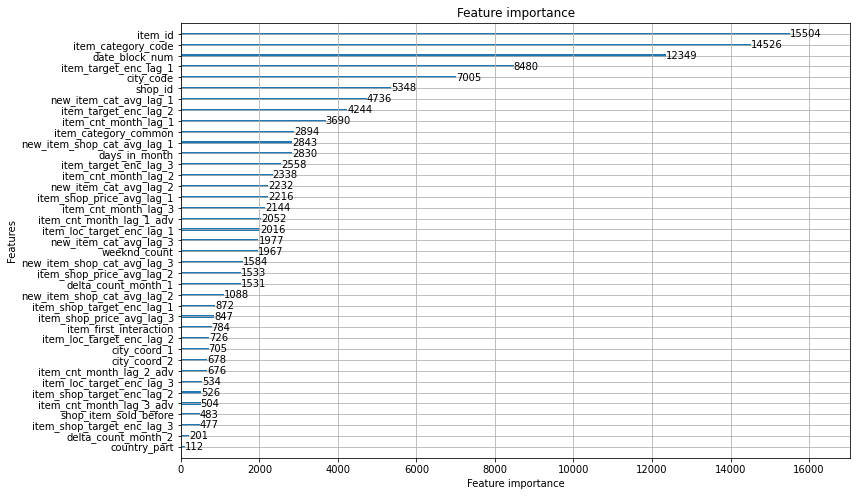

In [67]:
lgb.plot_importance(
    gbm, 
    max_num_features=50, 
    importance_type='split', 
    figsize=(12,8));

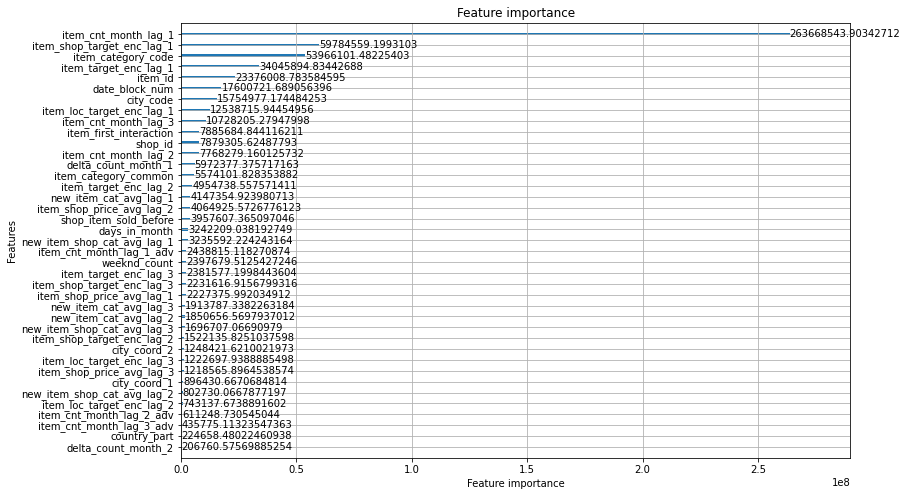

In [68]:
lgb.plot_importance(
    gbm, 
    max_num_features=50, 
    importance_type='gain', 
    figsize=(12,8));

In [ ]:
lgb.plot_importance(
    gbm, 
    max_num_features=50, 
    importance_type='gain', 
    figsize=(12,8));

In [ ]:
#items_subset = items[['item_id', 'item_name']]
#feature_count = 35
#tfidf = TfidfVectorizer(max_features=feature_count)
#items_df_item_name_text_features = pd.DataFrame(tfidf.fit_transform(items_subset['item_name']).toarray())

#cols = items_df_item_name_text_features.columns
#for i in range(feature_count):
#    feature_name = 'item_name_tfidf_' + str(i)
#    items_subset[feature_name] = items_df_item_name_text_features[cols[i]]

#items_subset.drop('item_name', axis = 1, inplace = True)